# 代码实现

在这一节中，我们将编程实现图像拼接。

In [1]:
from utils import *

# 利用RANSAC算法剔除无效点
def compute_affine_xform(corners1, corners2, matches):
    
    # 设置最大迭代次数
    iteration = 50
    M_list = []
    
    # 存放每一次模型的正常样本个数
    inlier_num_list = []
    for _ in range(iteration):
        
        # 随机选择4个特征点对来拟合模型
        sample_index = random.sample(range(len(matches)), 4)
        x1_s, y1_s = corners1[matches[sample_index[0]][0]]
        x1_t, y1_t = corners2[matches[sample_index[0]][1]]
        x2_s, y2_s = corners1[matches[sample_index[1]][0]]
        x2_t, y2_t = corners2[matches[sample_index[1]][1]]
        x3_s, y3_s = corners1[matches[sample_index[2]][0]]
        x3_t, y3_t = corners2[matches[sample_index[2]][1]]
        x4_s, y4_s = corners1[matches[sample_index[3]][0]]
        x4_t, y4_t = corners2[matches[sample_index[3]][1]]
        
        # 编写矩阵A
        A = np.array([[x1_s, y1_s, 1, 0, 0, 0, 
                       -x1_t*x1_s, -x1_t*y1_s, -x1_t],
                      [0, 0, 0, x1_s, y1_s, 1, 
                       -y1_t*x1_s, -y1_t*y1_s, -y1_t],
                      [x2_s, y2_s, 1, 0, 0, 0, 
                       -x2_t*x2_s, -x2_t*y2_s, -x2_t],
                      [0, 0, 0, x2_s, y2_s, 1, 
                       -y2_t*x2_s, -y2_t*y2_s, -y2_t],
                      [x3_s, y3_s, 1, 0, 0, 0, 
                       -x3_t*x3_s, -x3_t*y3_s, -x3_t],
                      [0, 0, 0, x3_s, y3_s, 1, 
                       -y3_t*x3_s, -y3_t*y3_s, -y3_t],
                      [x4_s, y4_s, 1, 0, 0, 0, 
                       -x4_t*x4_s, -x4_t*y4_s, -x4_t],
                      [0, 0, 0, x4_s, y4_s, 1, 
                       -y4_t*x4_s, -y4_t*y4_s, -y4_t]
                      ])
        
        # 求解A的特征向量
        _,_, v = np.linalg.svd(A)
        
        # 取最小特征值对应的特征向量作为最终的结果
        M = np.reshape(v[-1], (3, 3))
        
        inlier_num = 0
        # 统计正常样本个数
        for (index1, index2) in matches:
            # coord是齐次坐标系的坐标
            coord1 = [corners1[index1][0], corners1[index1][1], 1]
            coord2 = [corners2[index2][0], corners2[index2][1], 1]
            # 计算将coord1齐次变换之后的坐标
            mapcoor = np.dot(M, coord1)
            # 将齐次坐标系中的w置为1
            mapcoor = mapcoor / mapcoor[-1]
            if np.linalg.norm(coord2 - mapcoor) < 5:
                inlier_num += 1
                
        # 将正常样本个数和对应的变换矩阵M记录在列表里
        M_list.append(M)
        inlier_num_list.append(inlier_num)
    
    # 获取列表中正常样本值最大的元素的下标
    best_index = np.argmax(inlier_num_list)
    # 获取对应的变换矩阵
    xform = M_list[best_index].astype(np.float64)
    
    # 统计属于模型异常样本的特征点对
    outlier_labels = []
    for (index1, index2) in matches:
        coord1 = [corners1[index1][0], corners1[index1][1], 1]
        coord2 = [corners2[index2][0], corners2[index2][1], 1]
        mapcoor = np.dot(xform, coord1)
        mapcoor = mapcoor/mapcoor[-1]
        if np.linalg.norm(coord2 - mapcoor) < 12:
            outlier_labels.append(1)
        else:
            outlier_labels.append(0)
    
    return xform, outlier_labels  

为了在绘制时能够体现出异常点对，我们改写第7章中的draw_matches()函数。

In [3]:
def draw_matches(image1, image2, corners1, corners2, 
                 matches, outliers=None):
    # 获得两张图像的分辨率
    h1, w1 = image1.shape
    h2, w2 = image2.shape
    hres = 0
    if h1 >= h2:
        hres = int((h1 - h2) / 2)
    
        # 将两张图像拼接成高度一致的图像，方便进行特征点对的比对
        match_image = np.zeros((h1, w1 + w2, 3), np.uint8)

        # 对R、G、B图像分别处理
        for i in range(3):
            match_image[: h1, : w1, i] = image1
            match_image[hres: hres + h2, w1: w1 + w2, i] = image2

        for i in range(len(matches)):
            m = matches[i]
            # 获得匹配的特征点对在图中的坐标
            pt1 = (int(corners1[m[0]][0]), int(corners1[m[0]][1]))
            pt2 = (int(corners2[m[1]][0] + w1), 
                   int(corners2[m[1]][1] + hres))
            # 将其圈出
            cv2.circle(match_image, pt1, 1, (0,255,0), 2)
            cv2.circle(match_image, (pt2[0], pt2[1]), 1, (0,255,0), 2)
            # 画线相连
            if outliers:
                cv2.line(match_image, pt1, pt2, (255, 0, 0))
            else:
                cv2.line(match_image, pt1, pt2, (0, 0, 255))
    else:
        hres = int((h2 - h1) / 2)
        
         # 将两张图像拼接成高度一致的图像，方便进行特征点对的比对
        match_image = np.zeros((h2, w1 + w2, 3), np.uint8)

        # 对R、G、B图像分别处理
        for i in range(3):
            match_image[hres: hres + h1, : w1, i] = image1
            match_image[: h2, w1: w1 + w2, i] = image2

        for i in range(len(matches)):
            m = matches[i]
            # 获得匹配的特征点对在图中的坐标
            pt1 = (int(corners1[m[0]][0]), 
                   int(corners1[m[0]][1] + hres))
            pt2 = (int(corners2[m[1]][0] + w1), 
                   int(corners2[m[1]][1]))
            # 将其圈出
            cv2.circle(match_image, pt1, 1, (0,255,0), 2)
            cv2.circle(match_image, (pt2[0], pt2[1]), 1, (0,255,0), 2)
            # 画线相连
            if outliers:
                cv2.line(match_image, pt1, pt2, (255, 0, 0))
            else:
                cv2.line(match_image, pt1, pt2, (0, 0, 255))
        
    return match_image

在此之后，我们编写图像变换与缝合的相关函数。

In [4]:
# 图像变换与缝合
def stitch_images(image1, image2, xform):
    # 将图像按照变换矩阵的方向进行变换
    new_image = cv2.warpPerspective(image1, xform, 
                        (image2.shape[1],image2.shape[0]))
    image = new_image.copy()
    
    # 获取变换后的图像位置坐标
    h, w, _ = image1.shape
    pts = np.float32([[0, 0],
                      [0, h - 1],
                      [w - 1, h - 1],
                      [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, xform)
    
    # 画出缝合线
    image = cv2.polylines(image2, [np.int32(dst)], True, 
                          255, 1, cv2.LINE_AA)
    
    # 将重叠部分的图像求平均
    image = np.where(new_image>0, 0.5*new_image+0.5*image, image)
    return image.astype(np.uint8)

导入两张图像$\boldsymbol{A}$和$\boldsymbol{B}$，我们先计算图像的变换矩阵。

[]

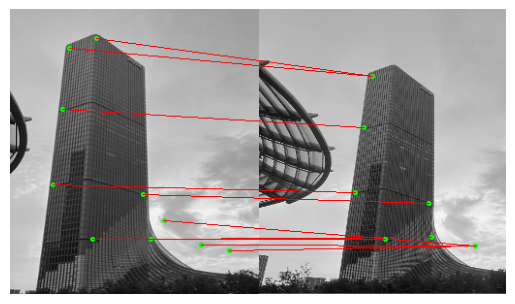

In [5]:
# 读取图像
img1 = cv2.imread('stitch1.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('stitch2.jpg', cv2.IMREAD_COLOR)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0

g_images1, corners1, scales1, orientations1, layers1 = \
                                        detect_blobs(gray1)
g_images2, corners2, scales2, orientations2, layers2 = \
                                        detect_blobs(gray2)

# 计算两张图像的特征点
descriptors1 = compute_descriptors(g_images1, corners1, scales1, 
                                   orientations1, layers1)
descriptors2 = compute_descriptors(g_images2, corners2, scales2, 
                                   orientations2, layers2)

# 匹配两张图像中的特征点
matches = match_descriptors(descriptors1, descriptors2)

image1 = cv2.imread('stitch1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('stitch2.jpg', cv2.IMREAD_GRAYSCALE)

# xform为变换矩阵，outlier_labels为模型的异常样本
xform, outlier_labels = compute_affine_xform(corners1, corners2, 
                                             matches) 
# 展示两张图像特征点的匹配
match_image = draw_matches(image1, image2, corners1, corners2, 
                           matches, outliers=outlier_labels)

plt.imshow(match_image)
plt.axis('off')
plt.plot()    


在此之后，我们将其中一张图像进行变换，并与另一张图像拼接。

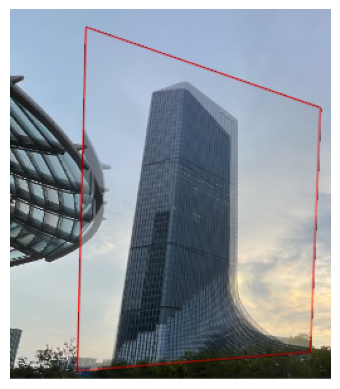

In [6]:
# 假设 img1 和 img2 是 BGR 格式的图像，将它们转换为 RGB
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# 使用转换后的 RGB 图像拼接
image = stitch_images(img1_rgb, img2_rgb, xform)

# 确保图像是 uint8 格式，然后显示
plt.imshow(image.astype(np.uint8))
plt.axis('off')
plt.show()